------
### Metis: Project McNulty 
>  Neha Gupta                
>  Date: 02/13/2019
-------

### Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

In [2]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

#### Upload Files through Spark

__Upload bids file__

In [3]:
df_bids = spark.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('bids_gc.csv')
df_bids.createOrReplaceTempView('bids')

spark.sql('select * from bids limit 5').show()

spark.sql('select count(*) from bids').show()

+------+--------------------+-------+-----------+------+----------------+-------+--------------+---------------+
|bid_id|           bidder_id|auction|merchandise|device|            time|country|            ip|            url|
+------+--------------------+-------+-----------+------+----------------+-------+--------------+---------------+
|     0|8dac2b259fd1c6d11...|  ewmzr|    jewelry|phone0|9759243157894736|     us| 69.166.231.58|vasstdc27m7nks3|
|     1|668d393e858e81262...|  aeqok|  furniture|phone1|9759243157894736|     in| 50.201.125.84|jmqlhflrzwuay9c|
|     2|aa5f360084278b35d...|  wa00e| home goods|phone2|9759243157894736|     py|112.54.208.157|vasstdc27m7nks3|
|     3|3939ac3ef7d472a59...|  jefix|    jewelry|phone4|9759243157894736|     in| 18.99.175.133|vasstdc27m7nks3|
|     4|8393c48eaf4b8fa96...|  jefix|    jewelry|phone5|9759243157894736|     in|  145.138.5.37|vasstdc27m7nks3|
+------+--------------------+-------+-----------+------+----------------+-------+--------------+

__Upload train file__

In [4]:
df_train = spark.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('train_gc.csv')
df_train.createOrReplaceTempView('train')

spark.sql('select * from train limit 5').show()

spark.sql('select count(*) from train').show()

+--------------------+--------------------+--------------------+-------+
|           bidder_id|     payment_account|             address|outcome|
+--------------------+--------------------+--------------------+-------+
|91a3c57b13234af24...|a3d2de7675556553a...|a3d2de7675556553a...|    0.0|
|624f258b49e77713f...|a3d2de7675556553a...|ae87054e5a97a8f84...|    0.0|
|1c5f4fc669099bfbf...|a3d2de7675556553a...|92520288b50f03907...|    0.0|
|4bee9aba2abda51bf...|51d80e233f7b6a7df...|4cb9717c8ad7e88a9...|    0.0|
|4ab12bc61c82ddd9c...|a3d2de7675556553a...|2a96c3ce94b3be921...|    0.0|
+--------------------+--------------------+--------------------+-------+

+--------+
|count(1)|
+--------+
|    2013|
+--------+



# Features Extraction

__Feature of counts: Counts of distinct values for a bidder__

In [5]:
feature_of_counts= spark.sql('''
select 
    bidder_id,
    count(distinct bid_id) as bid_count,
    count(distinct auction) as auction_count,
    count(distinct merchandise) as merc_count,
    count(distinct device) as device_count,
    count(distinct country) as country_count,
    count(distinct ip) as ip_count,
    count(distinct url) as url_count
from bids
group by bidder_id''')
feature_of_counts.createOrReplaceTempView('feature_of_counts')

__Feature of averages: Average of distinct values per auction__

In [6]:
feature_of_avgs= spark.sql(''' 
select 
    a.bidder_id, 
    sum(num_country)/count(distinct auction) average_distinct_country_per_auction,
    sum(num_urls)/count(distinct auction) average_distinct_urls_per_auction,
    sum(num_ips)/count(distinct auction) average_distinct_ip_per_auction,
    sum(num_devices)/count(distinct auction) average_distinct_dev_per_auction,
    sum(num_merc)/count(distinct auction) average_distinct_merc_per_auction,
    sum(num_bids)/count(distinct auction) average_bids_per_auction,
    count(distinct a.auction) num_auction
from (
    select 
        bidder_id,
        auction,
        count(distinct bid_id) num_bids,
        count(distinct country) num_country,
        count(distinct url) num_urls,
        count(distinct ip) num_ips,
        count(distinct device) num_devices,
        count(distinct merchandise) num_merc
    from bids 
    group by bidder_id,auction) a 
group by a.bidder_id''')
feature_of_avgs.createOrReplaceTempView('feature_of_avgs')

__Feature of time series: Resonse time in auctions by a bidder__

In [7]:
time_lag_feature = spark.sql('''
select 
    bidder_id,  
    percentile_approx(delta,0.5) as median_response_time 
from 
    (SELECT 
        bidder_id, 
        auction, 
        time - lag(time, 1) OVER (partition by bidder_id,auction ORDER BY time) delta
     FROM bids) a
group by 1''')
time_lag_feature.createOrReplaceTempView('time_lag_feature')

__Feature of time series: Average response time across auctions__

In [8]:
across_auction_time_lag_feature = spark.sql('''
select
 bidder_id, percentile_approx(delta,0.5) as avg_response_time_across_auctions from (
select
    bidder_id,
    auction,
    first_bid_time - lag(first_bid_time, 1) OVER (partition by bidder_id ORDER BY first_bid_time) delta
from
    (SELECT 
        bidder_id, 
        auction, 
        Min(time) first_bid_time
     FROM bids group by 1,2 order by bidder_id) a) b group by 1''')
across_auction_time_lag_feature.createOrReplaceTempView('across_auction_time_lag_feature')

__Feature of count: total no of won auctions__

In [9]:
won_auctions = spark.sql('''
select
  count(distinct auction) as num_auction_won,
  bidder_id
from (
select
 auction,
 bidder_id,
 rank() over (partition by auction order by time desc) as winner_rank
from bids 
) a where winner_rank = 1
group by bidder_id''')
won_auctions.createOrReplaceTempView('won_auctions')

__Feature of percentage: Average bid count per auction and no. of competitors__

In [10]:
bid_percent = spark.sql('''
select 
b.bidder_id, 
sum(b.bids_by_bidder_in_auction)/sum(a.bids_in_auction) as avg_bids_auction, 
sum(a.other_bidders_in_auction)/count(distinct a.auction) as competitors
from 
  (
     select 
       count(*) bids_in_auction,
       count(distinct bidder_id) other_bidders_in_auction,
       auction 
     from bids
     group by auction
  ) a 
  inner join 
  (
    select 
      bidder_id, 
      auction, 
      count(*) bids_by_bidder_in_auction 
    from 
    bids 
    group by bidder_id,auction
  ) b on a.auction = b.auction 
group by bidder_id''')
bid_percent.createOrReplaceTempView('bid_percent')

__Feature of time series: Median response time of a bidder and __

In [11]:
time_to_respond = spark.sql('''
select
 bidder_id,
 percentile_approx(time_to_respond_comp,0.5) as median_time_to_respond_competition,
 percentile_approx(time_to_respond_self,0.5) as median_time_to_respond_self
 from (
  Select
  bidder_id,
  case when bidder_id != previous_bidder_id
      then (time - time_to_respond_competiton)
      else 0
  end as time_to_respond_comp,
  time_to_respond_self
  from
    (SELECT 
        bidder_id, 
        auction, 
        time,
        lag(bidder_id,1) over (partition by auction order by time) as previous_bidder_id,
        lag(time, 1) over (partition by auction order by time) as time_to_respond_competiton,
        nvl(time - lag(time, 1) over (partition by auction,bidder_id order by time), -1) as time_to_respond_self
    from bids) a
) b
group by bidder_id
''')
time_to_respond.createOrReplaceTempView('time_to_respond')


__All Features joined with train data__

In [12]:
feature_of_all_train= spark.sql('''
select 
    a.bidder_id,
    a.bid_count,
    a.auction_count,
    a.merc_count,
    a.device_count,
    a.country_count,
    a.ip_count,
    a.url_count,
    round(b.average_distinct_country_per_auction,3) average_distinct_country_per_auction, 
    round(b.average_distinct_urls_per_auction,3) average_distinct_urls_per_auction,
    round(b.average_distinct_ip_per_auction,3) average_distinct_ip_per_auction,
    round(b.average_distinct_dev_per_auction,3) average_distinct_dev_per_auction,
    round(b.average_distinct_merc_per_auction,3) average_distinct_merc_per_auction,
    round(b.average_bids_per_auction,3) average_bids_per_auction,
    nvl(tl.median_response_time,0) median_response_time,
    nvl(aatl.avg_response_time_across_auctions,0) median_response_time_across_auction,
    b.num_auction,
    nvl(wa.num_auction_won,0) num_auction_won,
    nvl(wa.num_auction_won,0)/b.num_auction percentage_win,
    bp.avg_bids_auction,
    bp.competitors,
    tr.median_time_to_respond_competition,
    tr.median_time_to_respond_self,
    t.outcome
from feature_of_counts a 
    join train t 
        on a.bidder_id = t.bidder_id
    join feature_of_avgs b 
        on t.bidder_id = b.bidder_id 
    join time_lag_feature tl
        on b.bidder_id = tl.bidder_id
    join across_auction_time_lag_feature aatl
        on tl.bidder_id = aatl.bidder_id
    join bid_percent bp
        on aatl.bidder_id = bp.bidder_id
    join time_to_respond tr
        on bp.bidder_id = tr.bidder_id
    left outer join won_auctions wa
        on tr.bidder_id = wa.bidder_id''')


feature_of_all_train.count()

1984

__Creating csv file__

In [13]:
feature_of_all_train.repartition(1).write.format("com.databricks.spark.csv").option("header","true").save("train_data_withfeatures")

In [14]:
csv = pd.read_csv('train_data_withfeatures/saved.csv')
csv.shape

(1984, 24)

In [31]:
csv.head()

,bidder_id,bid_count,auction_count,merc_count,device_count,country_count,ip_count,url_count,average_distinct_country_per_auction,average_distinct_urls_per_auction,...,median_response_time,median_response_time_across_auction,num_auction,num_auction_won,percentage_win,avg_bids_auction,competitors,median_time_to_respond_competition,median_time_to_respond_self,outcome
0,001068c415025a009fee375a12cff4fcnht8y,1,1,1,1,1,1,1,1.000,1.000,...,0,0,1,0,0.000000,0.000492,153.000000,3842105263,-1,0.0
1,0030a2dd87ad2733e0873062e4f83954mkj86,1,1,1,1,1,1,1,1.000,1.000,...,0,0,1,0,0.000000,0.000036,425.000000,736842106,-1,0.0
2,00a0517965f18610417ee784a05f494d4dw6e,141,74,1,67,16,103,84,1.000,1.757,...,515315789474,180473684210,74,0,0.000000,0.000262,232.000000,947368421,-1,0.0
3,00cc97158e6f4cb8eac3c0075918b7ffi5k8o,3,3,1,3,2,3,1,1.000,1.000,...,0,54052631579,3,0,0.000000,0.000159,376.000000,157894737,-1,0.0
4,01067975436d123f717ee5aba0dd4bbfa0937,543,17,1,165,71,398,4,4.882,1.118,...,15631578947,371789473684,17,1,0.058824,0.002174,142.882353,52631579,15000000000,0.0


In [ ]:
# feature_of_all_test.repartition(1).write.format("com.databricks.spark.csv").option("header", "true").save("test_data_withfeature.csv")

__Joining bids and train files__

In [15]:
bids_join_train= spark.sql('''
select a.*, b.outcome from bids a inner join train b on a.bidder_id = b.bidder_id
''')
bids_join_train.createOrReplaceTempView('bids_join_train')

__Calculating no of Bots and Human__

In [16]:
hu_vs_bots = spark.sql('''
select 
        outcome,
        max(c_by_outcome) c_by_outcome, 
        max(perc_bids) perc_bids, 
        max(perc_a_h_v_b) perc_a_h_v_b, 
        max(t_c) t_c,
        avg(perc_by_auction) as avg_bids_by_auction
from
    (select 
        distinct 
            outcome,
            auction, 
            count(*) over(partition by outcome) c_by_outcome,
            count(*) over(partition by auction,outcome)/count(*) over(partition by auction) as perc_by_auction, 
            count(*) over(partition by outcome) /count(*) over () perc_bids,
            sum(wa.num_auction_won) over(partition by outcome)/sum(wa.num_auction_won) over() perc_a_h_v_b,
            count(*) over() t_c
    from 
        bids_join_train bt 
            left outer join 
        won_auctions wa
            on bt.bidder_id = wa.bidder_id) a 
    group by outcome
''')
hu_vs_bots.createOrReplaceTempView('hu_vs_bots')

In [17]:
hu_vs_bots.show()

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/data/samaurya/anaconda/lib/python3.8/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/data/samaurya/anaconda/lib/python3.8/site-packages/py4j/clientserver.py", line 475, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/data/samaurya/anaconda/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

__Making sure that spark generate one file of all data__

In [15]:
bids_join_train.repartition(1).write.format("com.databricks.spark.csv").option("header", "true").save("bids_join_train.csv")

### Visualizations for EDA

__Uploading newly generated file with all features__

In [309]:
df_bids_outcome = pd.read_csv('data.csv')

In [310]:
df_bids_outcome.head()

,Unnamed: 0,bidder_id,payment_account,address,outcome,bid_id,auction,merchandise,device,time,country,ip,url
0,0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,85371.0,yitr4,home goods,phone35,9.759489e+15,ke,82.34.177.248,vasstdc27m7nks3
1,1,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,274487.0,btpyy,home goods,phone1004,9.760249e+15,zm,202.130.71.167,vasstdc27m7nks3
2,2,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,527436.0,kj2ko,home goods,phone4,9.762261e+15,ke,22.54.76.225,vasstdc27m7nks3
3,3,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,554135.0,1m5t8,home goods,phone4,9.762431e+15,ke,32.13.237.126,vasstdc27m7nks3
4,4,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,607628.0,btpyy,home goods,phone4,9.762789e+15,ke,202.236.188.240,vasstdc27m7nks3


In [311]:
group_df=[]

group_df.append(pd.DataFrame(df_bids_outcome.groupby(['bidder_id','outcome']).size().reset_index(name = "bid_count")).dropna())
group_df.append(pd.DataFrame(df_bids_outcome.groupby(['auction']).size().reset_index(name = "bid_count")).dropna())
group_df.append(pd.DataFrame(df_bids_outcome.groupby(['merchandise']).size().reset_index(name = "bid_count")).dropna())
group_df.append(pd.DataFrame(df_bids_outcome.groupby(['country']).size().reset_index(name = "bid_count")).dropna())
names = ['by = bidder_id', 'by = auction', 'by = merchandise', 'by = country']


__Log distribution plot of bid counts__

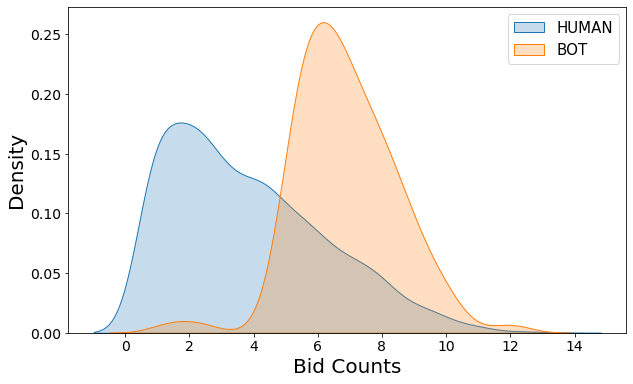

In [312]:
import math


def get_log(num):
    return math.log(num)


bidder_outcome_df = pd.DataFrame(df_bids_outcome.groupby(['bidder_id','outcome']).size().reset_index(name = "bid_count")).dropna()
bidder_outcome_df['log'] = list(map(get_log, bidder_outcome_df['bid_count']))
final_bidder_outcome_df = bidder_outcome_df[bidder_outcome_df['log'] != 0]
final_bidder_outcome_df
plt.figure(figsize=(10,6))
a = sns.kdeplot(final_bidder_outcome_df.loc[final_bidder_outcome_df.outcome==0, 'log'], shade=True, label='human');
sns.kdeplot(final_bidder_outcome_df.loc[final_bidder_outcome_df.outcome==1, 'log'], shade=True, ax=a, label='bot');
plt.xlabel('Bid Counts',fontsize=20)
plt.ylabel('Density',fontsize=20)
plt.legend(('HUMAN','BOT'), loc='upper right',fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('bid_count.png') 


__Log distribution plot of bid counts by auctions__

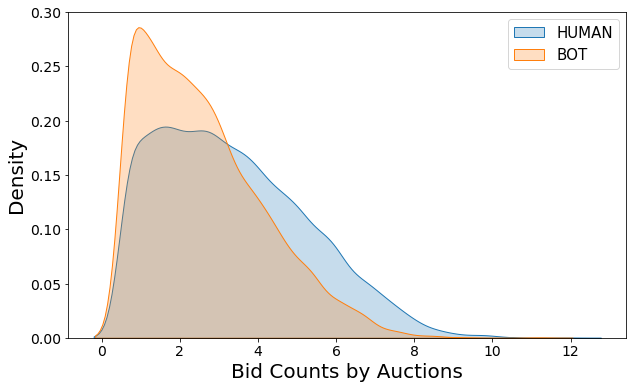

In [313]:
import math

def get_log(num):
    return math.log(num)

bid_count_auction = pd.DataFrame(df_bids_outcome.groupby(['auction','outcome']).size().reset_index(name = "bid_count")).dropna()

bid_count_auction['log'] = list(map(get_log, bid_count_auction['bid_count']))
final_bidder_outcome_df = bid_count_auction[bid_count_auction['log'] != 0]
final_bidder_outcome_df
plt.figure(figsize=(10, 6))
a = sns.kdeplot(final_bidder_outcome_df.loc[final_bidder_outcome_df.outcome == 0, 'log'], shade=True, label='human');
sns.kdeplot(final_bidder_outcome_df.loc[final_bidder_outcome_df.outcome == 1, 'log'], shade=True, ax=a, label='bot');
plt.xlabel('Bid Counts by Auctions',fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(('HUMAN', 'BOT'), loc='upper right', fontsize=15)
plt.savefig('bid_count_auction.png') 

__Log distribution plot of IP counts by auctions__

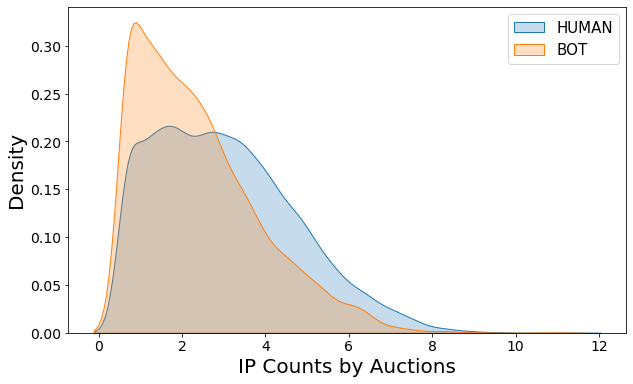

In [314]:
ip_counts = pd.DataFrame(df_bids_outcome.groupby(['auction','outcome']).ip.nunique().reset_index(name = "ip_counts")).dropna()

ip_counts['log'] = list(map(get_log, ip_counts['ip_counts']))
final_bidder_outcome_df = ip_counts[ip_counts['log'] != 0]
final_bidder_outcome_df
plt.figure(figsize=(10, 6))
a = sns.kdeplot(final_bidder_outcome_df.loc[final_bidder_outcome_df.outcome == 0, 'log'], shade=True, label='human');
sns.kdeplot(final_bidder_outcome_df.loc[final_bidder_outcome_df.outcome == 1, 'log'], shade=True, ax=a, label='bot');
plt.xlabel('IP Counts by Auctions', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(('HUMAN', 'BOT'), loc='upper right', fontsize=15)
plt.savefig('ip_count_auction.png') 


__Log distribution plot of merchandise counts by auctions__

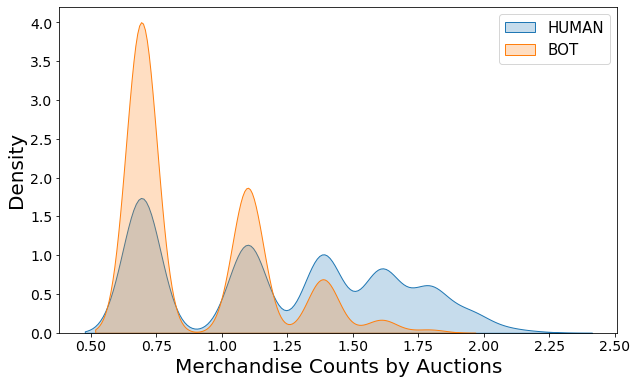

In [315]:
merc_counts = pd.DataFrame(df_bids_outcome.groupby(['auction','outcome']).merchandise.nunique().reset_index(name = "merc_counts")).dropna()

merc_counts['log'] = list(map(get_log, merc_counts['merc_counts']))
final_bidder_outcome_df = merc_counts[merc_counts['log'] != 0]
final_bidder_outcome_df
plt.figure(figsize=(10, 6))
a = sns.kdeplot(final_bidder_outcome_df.loc[final_bidder_outcome_df.outcome == 0, 'log'], shade=True, label='human');
sns.kdeplot(final_bidder_outcome_df.loc[final_bidder_outcome_df.outcome == 1, 'log'], shade=True, ax=a, label='bot');
plt.xlabel('Merchandise Counts by Auctions', fontsize = 20)
plt.ylabel('Density',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(('HUMAN', 'BOT'), loc='upper right', fontsize=15)
plt.savefig('merc_count_auction.png') 

__Merchandise where Human and Bots are bidding__

In [28]:
merchandise = pd.DataFrame(df_bids_outcome.groupby(['outcome','merchandise']).size().reset_index(name = "bid_count")).dropna()
merchandise.loc[merchandise.outcome == 0].sort_values(by='bid_count', ascending=False)
plt.savefig('table')

In [29]:
merchandise.loc[merchandise.outcome == 1].sort_values(by='bid_count', ascending=False)

,outcome,merchandise,bid_count
16,1.0,sporting goods,230326
14,1.0,mobile,105138
13,1.0,jewelry,37101
12,1.0,home goods,18708
11,1.0,computers,11667
15,1.0,office equipment,7967
10,1.0,books and music,1509


In [36]:
csv.head()

,bidder_id,bid_count,auction_count,merc_count,device_count,country_count,ip_count,url_count,average_distinct_country_per_auction,average_distinct_urls_per_auction,...,median_response_time,median_response_time_across_auction,num_auction,num_auction_won,percentage_win,avg_bids_auction,competitors,median_time_to_respond_competition,median_time_to_respond_self,outcome
0,001068c415025a009fee375a12cff4fcnht8y,1,1,1,1,1,1,1,1.000,1.000,...,0,0,1,0,0.000000,0.000492,153.000000,3842105263,-1,0.0
1,0030a2dd87ad2733e0873062e4f83954mkj86,1,1,1,1,1,1,1,1.000,1.000,...,0,0,1,0,0.000000,0.000036,425.000000,736842106,-1,0.0
2,00a0517965f18610417ee784a05f494d4dw6e,141,74,1,67,16,103,84,1.000,1.757,...,515315789474,180473684210,74,0,0.000000,0.000262,232.000000,947368421,-1,0.0
3,00cc97158e6f4cb8eac3c0075918b7ffi5k8o,3,3,1,3,2,3,1,1.000,1.000,...,0,54052631579,3,0,0.000000,0.000159,376.000000,157894737,-1,0.0
4,01067975436d123f717ee5aba0dd4bbfa0937,543,17,1,165,71,398,4,4.882,1.118,...,15631578947,371789473684,17,1,0.058824,0.002174,142.882353,52631579,15000000000,0.0


## View class balance

In [38]:
csv['outcome'].value_counts()

0.0    1881
1.0     103
Name: outcome, dtype: int64

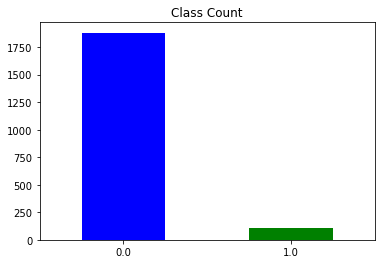

In [39]:
csv['outcome'].value_counts().plot(kind='bar', color=['b', 'g'], title='Class Count', rot=0)
plt.savefig('count') 

# --------------Adding more features from Leoreja (Stanford) repo----------------------------

In [235]:
csv = pd.read_csv('train_data_withfeatures1/saved.csv')

In [79]:
bids = pd.read_csv('bids_gc.csv')

In [80]:
bids_g_bidder = bids.groupby('bidder_id')
bids_g_auction = bids.groupby('auction')

In [81]:
def generate_time_features_per_bidder(group):
    sorted_group = group.sort_values(by=['time'])
    
    time_diff = np.ediff1d(sorted_group['time'])
    if len(time_diff) == 0:
        features = {'tdiff_min':0, 
                    'tdiff_max':0,
                    'tdiff_mean':0,
                    'tdiff_std':0,
                    'tdiff_median':0,
                    'tdiff_zeros':0}
    else:
        features = {'tdiff_min':np.min(time_diff), 
                    'tdiff_max':np.max(time_diff),
                    'tdiff_mean':np.mean(time_diff),
                    'tdiff_std':np.std(time_diff),
                    'tdiff_median':np.median(time_diff),
                    'tdiff_zeros':time_diff.shape[0]-np.count_nonzero(time_diff)}
    
    return pd.Series(features)
    
time_feat_per_bidder = bids_g_bidder.apply(generate_time_features_per_bidder)
print(time_feat_per_bidder.info())
print(time_feat_per_bidder.head(10))
#time_feat_per_bidder.to_csv('tdiff_feat_per_bidder.csv')

<class 'pandas.core.frame.DataFrame'>
Index: 6614 entries, 001068c415025a009fee375a12cff4fcnht8y to fff2c070d8200e0a09150bd81452ce29ngcnv
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   tdiff_min     6614 non-null   float64
 1   tdiff_max     6614 non-null   float64
 2   tdiff_mean    6614 non-null   float64
 3   tdiff_std     6614 non-null   float64
 4   tdiff_median  6614 non-null   float64
 5   tdiff_zeros   6614 non-null   float64
dtypes: float64(6)
memory usage: 361.7+ KB
None
                                          tdiff_min     tdiff_max  \
bidder_id                                                           
001068c415025a009fee375a12cff4fcnht8y  0.000000e+00  0.000000e+00   
002d229ffb247009810828f648afc2ef593rb  1.052632e+08  1.052632e+08   
0030a2dd87ad2733e0873062e4f83954mkj86  0.000000e+00  0.000000e+00   
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o  5.369263e+12  6.058642e+13   
00486a11dff552c4bd769626

In [82]:
def generate_price_features_per_bidder(group):
    features = {'price_min':np.min(group['time']), 
                'price_max':np.max(group['time']),
                'price_mean':np.mean(group['time']),
                'price_std':np.std(group['time']),
                'price_median':np.median(group['time'])}
    return pd.Series(features)
    
price_feat_per_bidder = bids_g_bidder.apply(generate_price_features_per_bidder)
print(price_feat_per_bidder.info())
print(price_feat_per_bidder.head(10))

<class 'pandas.core.frame.DataFrame'>
Index: 6614 entries, 001068c415025a009fee375a12cff4fcnht8y to fff2c070d8200e0a09150bd81452ce29ngcnv
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price_min     6614 non-null   float64
 1   price_max     6614 non-null   float64
 2   price_mean    6614 non-null   float64
 3   price_std     6614 non-null   float64
 4   price_median  6614 non-null   float64
dtypes: float64(5)
memory usage: 310.0+ KB
None
                                          price_min     price_max  \
bidder_id                                                           
001068c415025a009fee375a12cff4fcnht8y  9.706345e+15  9.706345e+15   
002d229ffb247009810828f648afc2ef593rb  9.766744e+15  9.766744e+15   
0030a2dd87ad2733e0873062e4f83954mkj86  9.704554e+15  9.704554e+15   
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o  9.640019e+15  9.705974e+15   
00486a11dff552c4bd7696265724ff81yeo9v  9.632637e+15  9.708986e+15  

In [83]:
from collections import defaultdict
time_response = defaultdict(list)

for auction in bids_g_auction:
    auction_group = auction[1].sort_values(by=['time'])
    last_row = None
    for i, row in auction_group.iterrows():
        if last_row is None:
            last_row = row
            continue
#         try:
#             assert row['time']-last_row['time'] >= 0
#         except:
#             print row['time'], last_row['time']
#             print auction_group['time']
#             break
        time_response[row['bidder_id']].append(row['time']-last_row['time'])
        last_row = row

time_response_df = []
for bidder_id in time_response.keys():
    time_response_df.append({'bidder_id':bidder_id,
                             'response_min': np.min(time_response[bidder_id]),
                             'response_max': np.max(time_response[bidder_id]),
                             'response_mean': np.mean(time_response[bidder_id]),
                             'response_std': np.std(time_response[bidder_id]),
                             'response_median': np.median(time_response[bidder_id])})
    
time_response_df = pd.DataFrame(time_response_df)
time_response_df.set_index('bidder_id')
print(time_response_df.info())
print(time_response_df.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6610 entries, 0 to 6609
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bidder_id        6610 non-null   object 
 1   response_min     6610 non-null   int64  
 2   response_max     6610 non-null   int64  
 3   response_mean    6610 non-null   float64
 4   response_std     6610 non-null   float64
 5   response_median  6610 non-null   float64
dtypes: float64(3), int64(2), object(1)
memory usage: 310.0+ KB
None
                               bidder_id  response_min    response_max  \
0  a939f51234ad2c44eb9ccc84e754f41foiv7g             0  71291894736842   
1  92af1e40713e077ef87f5352fb56772fjnzm7             0  72363263157895   
2  9655ccc7c0c193f1549475f02c54dce45kjw7             0  71655210526315   
3  84c4b58a1491da3a30710bcdf61f87054xfq6             0  73455578947368   
4  9a81137ad31d7253759cdb9ae8e44227fw8x9             0    480473684210   
5  31a7353958

In [84]:
def generate_tdiff_change_ip_features_per_bidder(group):
    group = group.sort_values(by=['time'])
    change_ip_rows = group.loc[group['ip'].shift() != group['ip']]
    change_time = np.ediff1d(change_ip_rows['time'])
    if len(change_time) == 0:
        res = 0
    else:
        res = np.median(change_time)
    return pd.Series(res)
    
tdiff_change_ip_feat_per_bidder = bids_g_bidder.apply(generate_tdiff_change_ip_features_per_bidder)
print(tdiff_change_ip_feat_per_bidder.info())
print(tdiff_change_ip_feat_per_bidder.head(10))

<class 'pandas.core.frame.DataFrame'>
Index: 6614 entries, 001068c415025a009fee375a12cff4fcnht8y to fff2c070d8200e0a09150bd81452ce29ngcnv
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       6614 non-null   float64
dtypes: float64(1)
memory usage: 103.3+ KB
None
                                                  0
bidder_id                                          
001068c415025a009fee375a12cff4fcnht8y  0.000000e+00
002d229ffb247009810828f648afc2ef593rb  0.000000e+00
0030a2dd87ad2733e0873062e4f83954mkj86  0.000000e+00
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o  3.297784e+13
00486a11dff552c4bd7696265724ff81yeo9v  1.427947e+12
0051aef3fdeacdadba664b9b3b07e04e4coc6  1.550263e+11
0053b78cde37c4384a20d2da9aa4272aym4pb  4.210526e+08
0061edfc5b07ff3d70d693883a38d370oy4fs  6.468421e+10
00862324eb508ca5202b6d4e5f1a80fc3t3lp  0.000000e+00
009479273c288b1dd096dc3087653499lrx3c  0.000000e+00


In [85]:
import math
# one_day = 4547368124071.8799
# startt = 9631916820392676.0
# delta = 2.16e10
# cutoff = 1.5e8 #cutoff for "small" time scales

# How to calculate time units
# start and end times for each three-day data segment
# -9631916842105263 + 9645558894736842 = 13642052631579  #week 0
# -9695580000000000 + 9709222052631578 = 13642052631578  #week 2
# -9759243157894736 + 9772885210526315 = 13642052631579  #week 4
# gap between end week 0, start week 2: 50021105263158
# gap between end week 2, start week 4: 50021105263158

def compute_entropy(array):
    entropy = np.sum(np.log(np.arange(1,array.shape[0])))
    for _, value in array.value_counts().iteritems():
        entropy -= np.sum(np.log(np.arange(1,value)))
    return entropy
def generate_entropy_features_per_bidder(group):
    feature = dict()
    feature['ip_entropy'] = compute_entropy(group['ip'])
    feature['url_entropy'] = compute_entropy(group['url'])
    return pd.Series(feature)

entropy_feat = bids_g_bidder.apply(generate_entropy_features_per_bidder)
print(entropy_feat.info())
print(entropy_feat.head(10))

<class 'pandas.core.frame.DataFrame'>
Index: 6614 entries, 001068c415025a009fee375a12cff4fcnht8y to fff2c070d8200e0a09150bd81452ce29ngcnv
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ip_entropy   6614 non-null   float64
 1   url_entropy  6614 non-null   float64
dtypes: float64(2)
memory usage: 155.0+ KB
None
                                         ip_entropy   url_entropy
bidder_id                                                        
001068c415025a009fee375a12cff4fcnht8y      0.000000      0.000000
002d229ffb247009810828f648afc2ef593rb      0.000000      0.000000
0030a2dd87ad2733e0873062e4f83954mkj86      0.000000      0.000000
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o      0.693147      0.693147
00486a11dff552c4bd7696265724ff81yeo9v     34.552392     23.542324
0051aef3fdeacdadba664b9b3b07e04e4coc6    108.281262     38.823934
0053b78cde37c4384a20d2da9aa4272aym4pb  55626.954427  56950.537277
0061edfc5b07ff3d70d6

In [152]:
csv.sort_values(by=['bidder_id'], inplace = True)

In [87]:
tdiff_change_ip_feat_per_bidder.head()

,0
bidder_id,
001068c415025a009fee375a12cff4fcnht8y,0.000000e+00
002d229ffb247009810828f648afc2ef593rb,0.000000e+00
0030a2dd87ad2733e0873062e4f83954mkj86,0.000000e+00
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,3.297784e+13
00486a11dff552c4bd7696265724ff81yeo9v,1.427947e+12


In [153]:
time_feat_per_bidder = time_feat_per_bidder.reset_index().sort_values(by=['bidder_id'])

In [154]:
price_feat_per_bidder = price_feat_per_bidder.reset_index().sort_values(by=['bidder_id'])

In [155]:
time_response_df = time_response_df.reset_index().sort_values(by=['bidder_id'])

In [63]:
# tdiff_change_ip_feat_per_bidder = tdiff_change_ip_feat_per_bidder.reset_index().sort_values(by=['bidder_id'])

In [135]:
# tdiff_change_ip_feat_per_bidder.rename(columns = {0:'ip_change'}, inplace = True)

In [156]:
entropy_feat = entropy_feat.reset_index().sort_values(by=['bidder_id'])

In [ ]:
----------------------------------------------------------------------

In [205]:
df = csv.copy()

In [246]:
df = pd.merge(csv, entropy_feat, on='bidder_id', how='left')

In [138]:
# df = pd.merge(df, tdiff_change_ip_feat_per_bidder, on='bidder_id', how='left')

In [247]:
time_response_df.drop(columns = ['index'], inplace = True)

In [248]:
df = pd.merge(df, time_response_df, on='bidder_id', how='left')

In [106]:
for ele in csv['bidder_id']:
    if ele not in time_response_df['bidder_id'].to_list():
        print(ele)

ca391c857d7aa75a72e2d7c3133e0d6ay9pil


In [210]:
df.isnull().sum()

bid_count                               0
auction_count                           0
merc_count                              0
device_count                            0
country_count                           0
ip_count                                0
url_count                               0
average_distinct_country_per_auction    0
average_distinct_urls_per_auction       0
average_distinct_ip_per_auction         0
average_distinct_dev_per_auction        0
average_distinct_merc_per_auction       0
average_bids_per_auction                0
median_response_time                    0
median_response_time_across_auction     0
num_auction                             0
num_auction_won                         0
percentage_win                          0
avg_bids_auction                        0
competitors                             0
median_time_to_respond_competition      0
outcome                                 0
ip_entropy                              0
url_entropy                       

In [249]:
df = pd.merge(df, price_feat_per_bidder, on='bidder_id', how='left')

In [127]:
time_feat_per_bidder.head()

,bidder_id,tdiff_min,tdiff_max,tdiff_mean,tdiff_std,tdiff_median,tdiff_zeros
0,001068c415025a009fee375a12cff4fcnht8y,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
1,002d229ffb247009810828f648afc2ef593rb,1.052632e+08,1.052632e+08,1.052632e+08,0.000000e+00,1.052632e+08,0.0
2,0030a2dd87ad2733e0873062e4f83954mkj86,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
3,003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,5.369263e+12,6.058642e+13,3.297784e+13,2.760858e+13,3.297784e+13,0.0
4,00486a11dff552c4bd7696265724ff81yeo9v,3.684211e+08,5.094174e+13,4.018413e+12,1.122958e+13,9.177368e+11,0.0


In [250]:
df = pd.merge(df, time_feat_per_bidder, on='bidder_id', how='left')

In [251]:
df = df.fillna(0)

In [263]:
df.to_csv('gc2_finalcsv1.csv', index = False)

In [236]:
df = csv.copy()

In [252]:
df.drop(columns = ['bidder_id'], inplace = True)

In [60]:
df.head()

,bid_count,auction_count,merc_count,device_count,country_count,ip_count,url_count,average_distinct_country_per_auction,average_distinct_urls_per_auction,average_distinct_ip_per_auction,...,price_max,price_mean,price_std,price_median,tdiff_min,tdiff_max,tdiff_mean,tdiff_std,tdiff_median,tdiff_zeros
0,1,1,1,1,1,1,1,1.000,1.000,1.000,...,9.706345e+15,9.706345e+15,0.000000e+00,9.706345e+15,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
1,1,1,1,1,1,1,1,1.000,1.000,1.000,...,9.704554e+15,9.704554e+15,0.000000e+00,9.704554e+15,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
2,141,74,1,67,16,103,84,1.000,1.757,1.676,...,9.709115e+15,9.695736e+15,2.174992e+13,9.703529e+15,5.263158e+08,5.012521e+13,5.486831e+11,4.235216e+12,5.615789e+10,0.0
3,3,3,1,3,2,3,1,1.000,1.000,1.000,...,9.696110e+15,9.659483e+15,2.589943e+13,9.641196e+15,5.405263e+10,5.491395e+13,2.748400e+13,2.742995e+13,2.748400e+13,0.0
4,543,17,1,165,71,398,4,4.882,1.118,23.647,...,9.772841e+15,9.765410e+15,3.613214e+12,9.765095e+15,5.263158e+07,9.704211e+11,2.507283e+10,5.327973e+10,1.405263e+10,0.0


In [354]:
len(df.columns)

39

In [324]:
df.head()

,bid_count,auction_count,merc_count,device_count,country_count,ip_count,url_count,average_distinct_country_per_auction,average_distinct_urls_per_auction,average_distinct_ip_per_auction,...,price_min,price_max,price_mean,price_std,price_median,tdiff_min,tdiff_max,tdiff_mean,tdiff_std,tdiff_median
0,1,1,1,1,1,1,1,1.000,1.000,1.000,...,9.706345e+15,9.706345e+15,9.706345e+15,0.000000e+00,9.706345e+15,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,1,1,1,1,1,1,1,1.000,1.000,1.000,...,9.704554e+15,9.704554e+15,9.704554e+15,0.000000e+00,9.704554e+15,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,141,74,1,67,16,103,84,1.000,1.757,1.676,...,9.632300e+15,9.709115e+15,9.695736e+15,2.174992e+13,9.703529e+15,5.263158e+08,5.012521e+13,5.486831e+11,4.235216e+12,5.615789e+10
3,3,3,1,3,2,3,1,1.000,1.000,1.000,...,9.641142e+15,9.696110e+15,9.659483e+15,2.589943e+13,9.641196e+15,5.405263e+10,5.491395e+13,2.748400e+13,2.742995e+13,2.748400e+13
4,543,17,1,165,71,398,4,4.882,1.118,23.647,...,9.759251e+15,9.772841e+15,9.765410e+15,3.613214e+12,9.765095e+15,5.263158e+07,9.704211e+11,2.507283e+10,5.327973e+10,1.405263e+10


In [325]:
df.shape

(1984, 39)

In [172]:
df.drop(columns = ['median_time_to_respond_self','median_time_to_respond_competition', 'tdiff_zeros'], inplace = True)

In [207]:
df.drop(columns = ['median_time_to_respond_self'], inplace = True)

In [255]:
df.drop(columns = ['tdiff_zeros'], inplace = True)

In [280]:
df.drop(columns = ['index', 'index_x', 'index_y'], inplace = True)

In [292]:
df.drop(columns = ['median_response_time'], inplace = True)

In [316]:
df.to_csv('gc2_finalcsv.csv', index = False)

In [238]:
from sklearn.ensemble import RandomForestClassifier
model3 = RandomForestClassifier(n_estimators=300, class_weight = 'balanced')

In [317]:
Y = df[['outcome']] # Target variable
X = df.drop(['outcome'], axis=1) # Train set (All columns except attack_type)

In [318]:
from sklearn.model_selection import train_test_split

In [319]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [320]:
model3.fit(X_train, Y_train.values.ravel())

RandomForestClassifier(class_weight='balanced', n_estimators=300)

In [321]:
Y_test_pred1 = model3.predict(X_test)

In [322]:
nb_train_score = model3.score(X_train,Y_train)
nb_test_score = model3.score(X_test,Y_test)

In [323]:
print("Train score: ",nb_train_score)
print("Test score: ",nb_test_score)

Train score:  1.0
Test score:  0.9546599496221663


In [300]:
df.head()

,bid_count,auction_count,merc_count,device_count,country_count,ip_count,url_count,average_distinct_country_per_auction,average_distinct_urls_per_auction,average_distinct_ip_per_auction,...,price_min,price_max,price_mean,price_std,price_median,tdiff_min,tdiff_max,tdiff_mean,tdiff_std,tdiff_median
0,1,1,1,1,1,1,1,1.000,1.000,1.000,...,9.706345e+15,9.706345e+15,9.706345e+15,0.000000e+00,9.706345e+15,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,1,1,1,1,1,1,1,1.000,1.000,1.000,...,9.704554e+15,9.704554e+15,9.704554e+15,0.000000e+00,9.704554e+15,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,141,74,1,67,16,103,84,1.000,1.757,1.676,...,9.632300e+15,9.709115e+15,9.695736e+15,2.174992e+13,9.703529e+15,5.263158e+08,5.012521e+13,5.486831e+11,4.235216e+12,5.615789e+10
3,3,3,1,3,2,3,1,1.000,1.000,1.000,...,9.641142e+15,9.696110e+15,9.659483e+15,2.589943e+13,9.641196e+15,5.405263e+10,5.491395e+13,2.748400e+13,2.742995e+13,2.748400e+13
4,543,17,1,165,71,398,4,4.882,1.118,23.647,...,9.759251e+15,9.772841e+15,9.765410e+15,3.613214e+12,9.765095e+15,5.263158e+07,9.704211e+11,2.507283e+10,5.327973e+10,1.405263e+10


In [301]:
import scikitplot as skplt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import cohen_kappa_score, confusion_matrix
import matplotlib.pyplot as plt


Testing Results of the trained model: 

Accuracy :  0.9546599496221663

Confusion Matrix :
 [[373   1]
 [ 17   6]]

Classification Report :
               precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       374
         1.0       0.86      0.26      0.40        23

    accuracy                           0.95       397
   macro avg       0.91      0.63      0.69       397
weighted avg       0.95      0.95      0.94       397



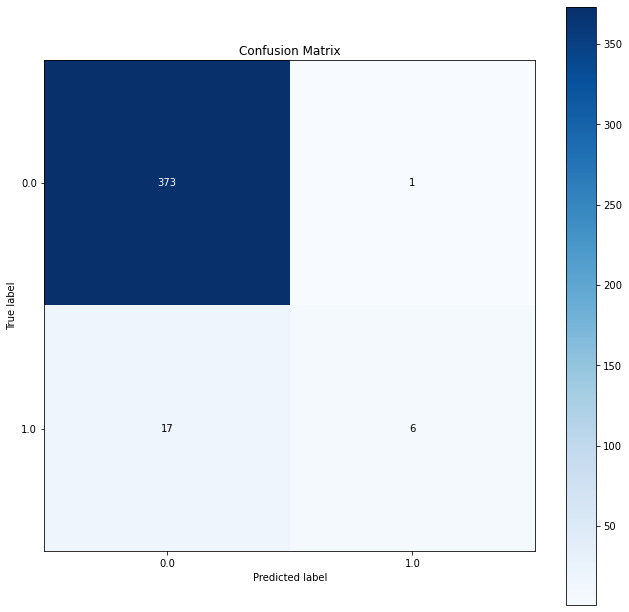

In [302]:
# Evaluate the skill of the Trained model
acc                 = accuracy_score(Y_test, Y_test_pred1)
classReport         = classification_report(Y_test, Y_test_pred1)
confMatrix          = confusion_matrix(Y_test, Y_test_pred1) 
        
print(); print('Testing Results of the trained model: ')
print(); print('Accuracy : ', acc)
print(); print('Confusion Matrix :\n', confMatrix)
print(); print('Classification Report :\n',classReport)
skplt.metrics.plot_confusion_matrix(Y_test, Y_test_pred1, figsize=(11,11)); plt.show()

In [303]:
importances = model3.feature_importances_
#
# Sort the feature importance in descending order
#
sorted_indices = np.argsort(importances)[::-1]

In [355]:
importances[sorted_indices]

array([9.68940026e-02, 9.61323300e-02, 9.35510510e-02, 6.84682724e-02,
       4.90350176e-02, 3.86187231e-02, 3.83873667e-02, 3.02042629e-02,
       2.73331951e-02, 2.71057000e-02, 2.41926516e-02, 2.37770130e-02,
       2.27803183e-02, 2.24876186e-02, 2.21276693e-02, 2.17626146e-02,
       2.15162638e-02, 2.07820820e-02, 2.03929966e-02, 1.93006480e-02,
       1.84977429e-02, 1.78317138e-02, 1.76438316e-02, 1.73401900e-02,
       1.71468097e-02, 1.65038981e-02, 1.58792196e-02, 1.44557448e-02,
       1.42165920e-02, 1.34781053e-02, 1.16238548e-02, 1.12690563e-02,
       1.07323746e-02, 9.13514904e-03, 4.89585597e-03, 4.50006411e-03,
       1.00213356e-17, 6.93587104e-19])

In [358]:
x = np.array([9.68940026e-02, 9.61323300e-02, 9.35510510e-02, 6.84682724e-02,
       3.86187231e-02, 3.83873667e-02, 
       2.73331951e-02, 2.71057000e-02, 2.41926516e-02, 2.37770130e-02,
       2.27803183e-02, 2.24876186e-02, 2.21276693e-02, 2.17626146e-02,
       2.15162638e-02, 2.07820820e-02, 2.03929966e-02, 1.93006480e-02,
       1.84977429e-02, 1.78317138e-02, 1.73401900e-02,
       1.71468097e-02, 1.65038981e-02, 1.58792196e-02, 1.44557448e-02,
       1.42165920e-02, 1.34781053e-02, 1.16238548e-02, 1.12690563e-02,
       1.07323746e-02, 9.13514904e-03, 4.89585597e-03, 4.50006411e-03,
       1.00213356e-17, 6.93587104e-19])

In [356]:
X_train.shape[1]

38

In [304]:
cols = X.columns

In [357]:
cols[sorted_indices]

Index(['bid_count', 'average_bids_per_auction', 'tdiff_median', 'tdiff_mean',
       'median_time_to_respond_self', 'avg_bids_auction', 'ip_entropy',
       'median_response_time_across_auction', 'price_std', 'response_max',
       'price_mean', 'tdiff_min', 'price_max', 'ip_count', 'response_median',
       'price_min', 'price_median', 'auction_count', 'competitors',
       'url_entropy', 'device_count', 'response_std',
       'median_time_to_respond_competition', 'tdiff_std', 'num_auction',
       'tdiff_max', 'average_distinct_dev_per_auction', 'response_mean',
       'average_distinct_ip_per_auction', 'url_count', 'country_count',
       'average_distinct_urls_per_auction',
       'average_distinct_country_per_auction', 'response_min',
       'num_auction_won', 'percentage_win', 'merc_count',
       'average_distinct_merc_per_auction'],
      dtype='object')

In [359]:
labels = ['bid_count', 'average_bids_per_auction', 'tdiff_median', 'tdiff_mean',
        'avg_bids_auction', 'ip_entropy',
        'price_std', 'response_max',
       'price_mean', 'tdiff_min', 'price_max', 'ip_count', 'response_median',
       'price_min', 'price_median', 'auction_count', 'competitors',
       'url_entropy', 'device_count', 'response_std',
        'tdiff_std', 'num_auction',
       'tdiff_max', 'average_distinct_dev_per_auction', 'response_mean',
       'average_distinct_ip_per_auction', 'url_count', 'country_count',
       'average_distinct_urls_per_auction',
       'average_distinct_country_per_auction', 'response_min',
       'num_auction_won', 'percentage_win', 'merc_count',
       'average_distinct_merc_per_auction']

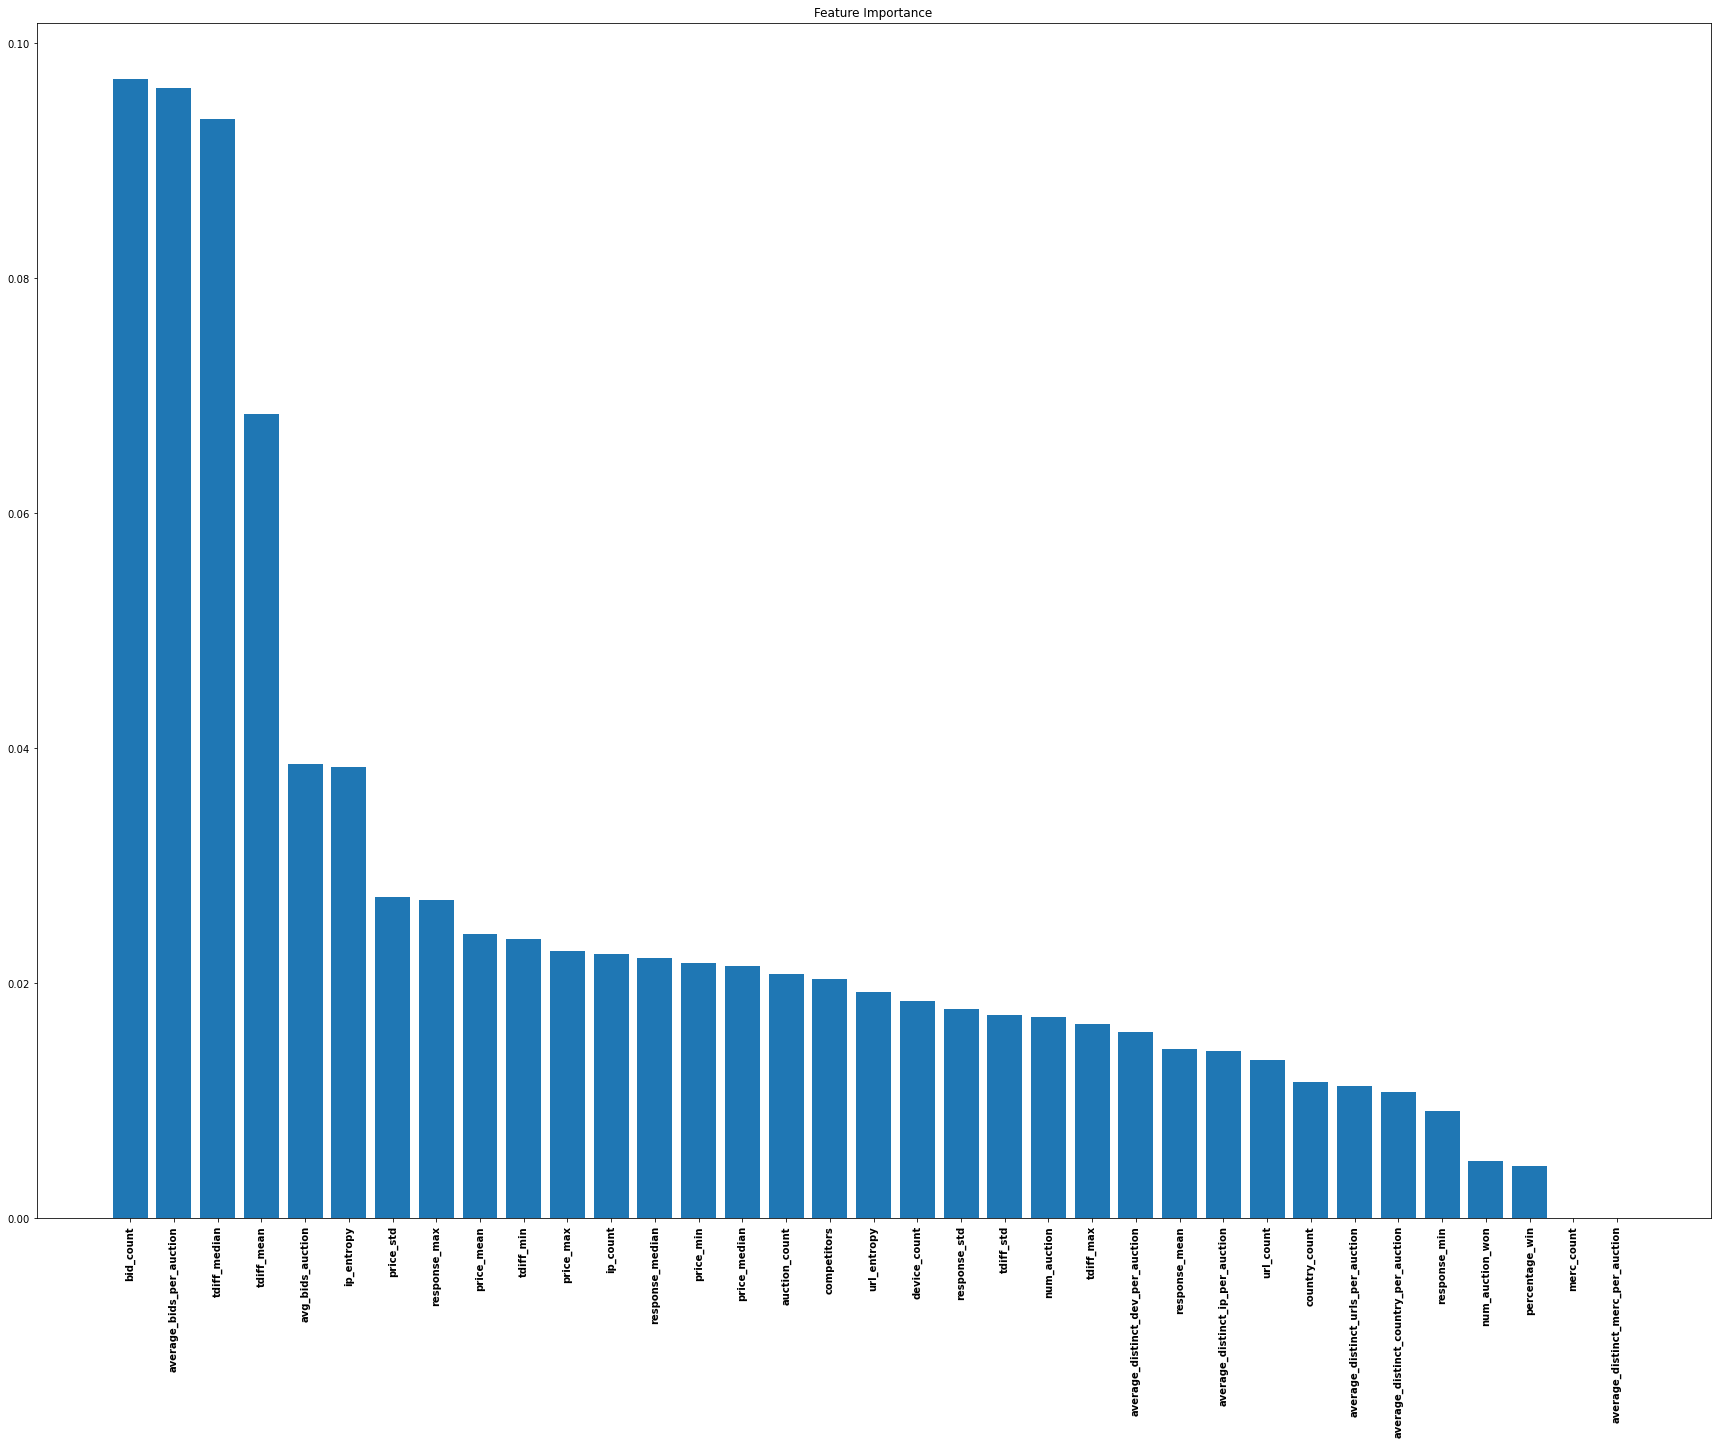

In [369]:
import matplotlib.pyplot as plt
 
plt.figure(figsize=(30,22))
plt.title('Feature Importance')
plt.bar(range(35), x)
plt.xticks(range(35), labels, rotation=90,weight = 'bold')
#plt.tight_layout()
#plt.show()
plt.savefig('features.png')

In [346]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(class_weight='balanced', max_iter = 1000)

In [330]:
from sklearn.preprocessing import StandardScaler

In [331]:
sc = StandardScaler()
XX = sc.fit_transform(X)

In [347]:
X_train, X_test, y_train, y_test = train_test_split(XX, Y, test_size=0.2, random_state=42)

In [348]:
lr.fit(X_train, y_train.values.ravel())

LogisticRegression(class_weight='balanced', max_iter=1000)

In [352]:
Y_test_pred2 = lr.predict(X_test)

In [349]:
nb_train_score = lr.score(X_train,Y_train)
nb_test_score = lr.score(X_test,Y_test)

In [350]:
nb_train_score

0.7693761814744802

In [351]:
nb_test_score

0.7984886649874056


Testing Results of the trained model: 

Accuracy :  0.7984886649874056

Confusion Matrix :
 [[297  77]
 [  3  20]]

Classification Report :
               precision    recall  f1-score   support

         0.0       0.99      0.79      0.88       374
         1.0       0.21      0.87      0.33        23

    accuracy                           0.80       397
   macro avg       0.60      0.83      0.61       397
weighted avg       0.94      0.80      0.85       397



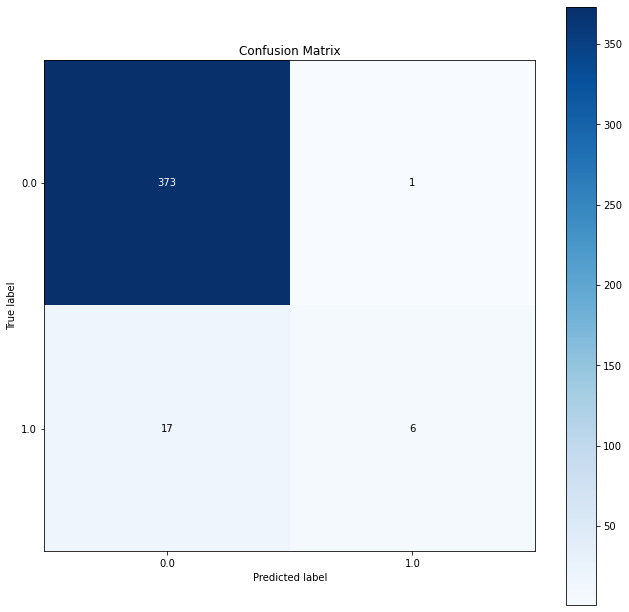

In [353]:
# Evaluate the skill of the Trained model
acc                 = accuracy_score(Y_test, Y_test_pred2)
classReport         = classification_report(Y_test, Y_test_pred2)
confMatrix          = confusion_matrix(Y_test, Y_test_pred2) 
        
print(); print('Testing Results of the trained model: ')
print(); print('Accuracy : ', acc)
print(); print('Confusion Matrix :\n', confMatrix)
print(); print('Classification Report :\n',classReport)
skplt.metrics.plot_confusion_matrix(Y_test, Y_test_pred1, figsize=(11,11)); plt.show()